## Image Caption Generator

YAPILACAKLAR

- dataset çok büyük, cache te tutabiliriz ( torch.save("filename.pt") şeklindeydi sanırım, bakalım ona ) ya da şimdi development aşamasında sadece bi kısmını alabiliriz (dataset = load_dataset("coco", split='train[:%10]')) gibi bişiydi bizde şu an  'dataset = load_dataset("coco", split='train[:%10]')' şeklinde. ya da başka bilmediğim bi yol varsa o da olur.

- Google Colab'de ya da herhangi biyerde çalışabilir hâle getirmek lazım, şu an bazı şeyler sorunlu olabilir, eklenmesi gereken şeyler olabilir

- Her method ne yapıyor nasıl çalışıyor iyice öğrenmek ve bunu nasıl geliştirebiliriz neler kullanabiliriz ya da neler eksik vs.
Bazı kavramlar yeni olacak, zorlanabilirsiniz, chatgpt ye soruyom ben de bolca :) ,gruba sorabilirsiniz, hallolcakkkk :)

Yapcazzz bu işiii <3


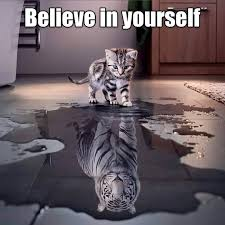


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import os
from PIL import Image
import numpy as np
import requests
from io import BytesIO
from datasets import load_dataset
from tqdm import tqdm
import cv2

# for metrics, COCO API metrics is used
import json
from pycocoevalcap.coco import COCO
from pycocoevalcap.evalcap import COCOEvalCap

# Load YOLOv5 for feature extraction
import torch.hub

ModuleNotFoundError: No module named 'torchtext'

In [ ]:
 #Uncomment below if you are using Google Colab.
""" !pip install torch torchvision torchaudio torchtext transformers datasets
    !pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI
    !pip install git+https://github.com/ultralytics/yolov5
"""


In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip

In [ ]:
# Load pre-trained YOLOv5 model from Torch Hub
yolov5 = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).eval().to(device)

In [ ]:
# Define transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Load COCO Dataset (captions and images)
dataset = load_dataset("coco", split='train')

In [ ]:
class CocoDataset(Dataset): # <start> cat sat on the mat <end> -> {0 32 24 34 3 3 1 }
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = load_dataset('json', data_files=annotation_file)['train']
        self.tokenizer = get_tokenizer("basic_english")  # Tokenizer from torchtext

        # Build vocabulary
        self.vocab = self.build_vocab()

    def build_vocab(self):
        counter = Counter()
        for annotation in tqdm(self.annotations):
            caption = annotation['caption']
            tokens = self.tokenizer(caption.lower())
            counter.update(tokens)
        vocab = build_vocab_from_iterator([counter], specials=["<pad>", "<unk>", "<bos>", "<eos>"])
        vocab.set_default_index(vocab["<unk>"])  # Out-of-vocabulary words will be mapped to <unk>
        return vocab

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations[idx]['file_name'])
        image = Image.open(img_path).convert('RGB')
        caption = self.annotations[idx]['caption']
        tokens = self.tokenizer(caption.lower())

        # Convert caption tokens to indices
        caption_indices = [self.vocab['<bos>']] + [self.vocab[token] for token in tokens] + [self.vocab['<eos>']]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(caption_indices)


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        self.cnn = yolov5.models.common.AutoShape(yolov5.load("yolov5s"))
        self.fc = nn.Linear(1000, embed_size)

    def forward(self, images):
        features = self.cnn(images)  # Get features from YOLOv5
        features = features.view(features.size(0), -1)
        features = self.fc(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        lstm_out, _ = self.lstm(inputs)
        output = self.fc(lstm_out)
        return output

class ImageCaptioningModel(nn.Module):
    def __init__(self, encoder, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    for images, captions in dataloader:
        images = torch.stack(images).to(device)
        captions = torch.stack(captions).to(device)

        optimizer.zero_grad()
        outputs = model(images, captions[:, :-1])  # Exclude last token in captions
        loss = criterion(outputs.view(-1, outputs.size(2)), captions[:, 1:].contiguous().view(-1))  # Teacher forcing
        loss.backward()
        optimizer.step()

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions in dataloader:
            images = torch.stack(images).to(device)
            captions = torch.stack(captions).to(device)

            outputs = model(images, captions[:, :-1])  # Exclude last token in captions
            loss = criterion(outputs.view(-1, outputs.size(2)), captions[:, 1:].contiguous().view(-1))  # Teacher forcing
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [ ]:
def generate_caption(image, model, vocab, device):
    model.eval()
    image = transform(image).unsqueeze(0).to(device)
    features = model.encoder(image)
    
    # Generate caption
    caption = ['<bos>']
    for _ in range(50):  # Maximum caption length
        input_caption = torch.tensor([vocab[token] for token in caption]).unsqueeze(0).to(device)
        outputs = model.decoder(features, input_caption)
        _, predicted = outputs.max(2)
        predicted_word = vocab.lookup_token(predicted[0, -1].item())
        caption.append(predicted_word)
        if predicted_word == '<eos>':
            break
    
    return ' '.join(caption[1:-1])  # Removing <bos> and <eos>

# Load trained model and generate a caption
model.load_state_dict(torch.load('image_captioning_model.pth'))
image = Image.open("path_to_image.jpg")  # Replace with your image path
caption = generate_caption(image, model, train_dataset.vocab, device)
print(f"Generated Caption: {caption}")


In [ ]:
# Hyperparameters
embed_size = 256
hidden_size = 512
num_epochs = 10
learning_rate = 0.001

# Instantiate Encoder, Decoder, and Model
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(train_dataset.vocab)).to(device)
model = ImageCaptioningModel(encoder, decoder).to(device)

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(num_epochs):
    train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

# Save the trained model
torch.save(model.state_dict(), 'image_captioning_model.pth')

In [ ]:
caption = generate_caption(encoder, decoder, 'path/to/your/image.jpg', vocab, transform, device)
print("Generated Caption:", caption)

In [ ]:


def evaluate_captioning_model(generated_captions, coco_annotation_file='annotations/captions_val2017.json'):
    """
    Evaluate the image captioning model using COCO evaluation metrics: BLEU, METEOR, ROUGE, CIDEr.

    Parameters:
        generated_captions (dict): Dictionary of generated captions with image_ids as keys.
        coco_annotation_file (str): Path to COCO annotations file.

    Returns:
        dict: Dictionary containing BLEU, METEOR, ROUGE, CIDEr scores.
    """
    # Load the COCO dataset annotations (reference captions)
    coco = COCO(coco_annotation_file)
    
    # Create a dictionary for the generated captions (image_id -> caption)
    coco_results = []
    for image_id, caption in generated_captions.items():
        coco_results.append({
            'image_id': image_id,
            'caption': caption
        })
    
    # Save the generated captions in a temporary file
    with open('generated_captions.json', 'w') as f:
        json.dump(coco_results, f)

    # Load the results into COCO's evaluation API
    coco_results = coco.loadRes('generated_captions.json')
    
    # Set up the evaluation
    coco_eval = COCOEvalCap(coco, coco_results)
    coco_eval.evaluate()

    # Extract and return the metrics (BLEU, METEOR, ROUGE, CIDEr)
    metrics = coco_eval.eval
    return metrics

# Example: Generated captions for some images
generated_captions = {
    12345: "A man in a black shirt is riding a bike.",
    67890: "A dog running through the grass.",
    11223: "A woman holding a book in her hand."
}

# Evaluate the generated captions
metrics = evaluate_captioning_model(generated_captions)
print("Evaluation Metrics:", metrics)